# **Model uczenia maszynowego predykcji oceny filmu w serwisie Filmweb**

# 1\. Wczytanie danych i niezbędnych bibliotek
Ta część projektu polega na stworzeniu modelu uczenia maszynowego dla wcześniej utworzonej i przeanalizowanej bazy danych filmów z portalu Filmweb. Ma na celu zaproponowanie modelu, który będzie w stanie przewidzieć średnią ocenę użytkowników dla filmu na podstawie innych danych. Do przeprowadzania uczenia maszynowego będę używać biblioteki *sklearn*. Zbiór danych, który został utworzony za pomocą scrapingu w 1 części projektu i zmodyfikowany w 2 importuję z pliku CSV.

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics, tree, ensemble, model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
df = pd.read_csv("wyniki.csv", encoding="utf-8", header=0, sep=";")

## 1.1 Preprocessing

Aby móc stworzyć model do przewidywania oceny filmu, muszę wybrać odpowiednie predyktory (zmienne objaśniające). Dlatego niektóre kolumny nie są mi już potrzebne w tym:
* Tytuł i Tytuł org. - brak wpływu na ocenę
* Liczba ocen oraz liczba poszczególnych ocen 1-10, Ocena krytyków, Liczba ocen krytyków, Box Office, Komentarze - brak wiedzy na temat tych danych przed premierą filmu
* Kraj i Typ długości - zamiast tego są kolumny Region i Długość
* Budżet - jedynie 3652/15966 filmów ma informacje na ten temat

Na razie decyduję się usunąć również kolumnę Scenariusz, ze względu na duże rozdrobnienie danych w tej kategorii (11265/15325 unikatowych wartości). Różnych reżyserów mamy mniej (7666/15911) dlatego wstępnie zostawię te informacje. Sprawdzam również ile w naszym zestawie danych jest wartości NaN.

In [3]:
df=df[[col for col in df.columns if not col.isdigit()]]
df.drop(["Tytuł","Tytuł org.","Liczba ocen","Chce zobaczyć","Ocena krytyków","Liczba ocen krytyków","Kraj","Box Office","Budżet","Komentarze","Typ długości","Scenariusz"], axis=1, inplace=True)
df.isna().sum()

Rok          0
Długość      9
Ocena        0
Reżyser     55
Gatunek    631
Region       0
dtype: int64

Ze względu na stosunkowo niewielką liczbę brakujących danych, decyduję się usunąć wszystkie wpisy, gdzie brakuje co najmniej jednej z wartości. Główną część NaN stanowią gatunki, którym w analizie eksploracyjnej nie przypisaliśmy żadnej z głównych kategorii.

In [4]:
df=df.dropna().reset_index(drop=True)
df.isna().sum()

Rok        0
Długość    0
Ocena      0
Reżyser    0
Gatunek    0
Region     0
dtype: int64

Na koniec wyświetlam dane, które pozostały w zbiorze danych. Będą one stanowiły postawę modelu uczenia maszynowego.

In [5]:
df.head(5)

,Rok,Długość,Ocena,Reżyser,Gatunek,Region
0,1991,118.0,8.24219,Jonathan Demme,Thriller,USA
1,1999,139.0,8.28509,David Fincher,Thriller,USA
2,1999,107.0,7.80946,M. Night Shyamalan,Thriller,USA
3,1995,127.0,8.30513,David Fincher,Akcja,USA
4,2010,138.0,8.18331,Martin Scorsese,Dramat,USA


Aby przygotować dane do zastosowania w modelach ML, klasyfikuję dane binarnie za pomocą funkcji **get_dummies**. Dodatkowo reżyserów może być kilku i wtedy rozdzieleni są przecinkami, więc również to uwzględniam. Następnie usuwam oryginalne kolumny Region, Reżyser i Gatunek, gdyż pozostałe dane są już przeniesione do nowych kolumn. Następnie wydzielam kolumnę Oceny jako y (zmienna prognozowana) i pozostałe dane jako X (zmienne objaśniające).

In [6]:
df = pd.concat([df, df["Gatunek"].str.get_dummies(), df["Region"].str.get_dummies(), df["Reżyser"].str.get_dummies(",")], axis=1)
df = df.drop(["Gatunek", "Region", "Reżyser"], axis=1)

X = df.drop("Ocena", axis=1)
y = df["Ocena"]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15277 entries, 0 to 15276
Columns: 8077 entries, Rok to Łukasz Wylężałek
dtypes: float64(1), int64(8076)
memory usage: 941.4 MB


Dokonuję teraz podziału na dane testowe i treningowe w stosunku 30:70. Jako random_state przyjmuję 1 dla powtarzalności podziału, a parametr shuffle zostawiam jako domyślny, czyli True. Skutkuje to tym, że zestaw danych treningowych i danych testowych będzie taki sam dla każdego wykonania, a wyniki będzie można ze sobą porównać. Dodatkowo będą one przed podziałem przemieszane, ponieważ podczas scrapingu były dodawane w kolejności popularności filmów oraz pogrupowane gatunkami.

Następnie standaryzuję dane, czyli przekształcam wartości tak, aby średnia wynosiła 0, a odchylenie standardowe 1. Używam do tego klasy o nazwie **StandardScaler**.
Dla danych treningowych korzystam z funkcji **fit_transform**, która najpierw oblicza średnią i odchylenie standardowe, a następnie transformuję dane. Dla danych testowych używam tylko funkcji **transform**.

In [7]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=1)
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
pd.DataFrame([[len(X_train), len(X_test)],[len(y_train), len(y_test)]], columns = ['train', 'test'], index=['X', 'y'])

,train,test
X,10693,4584
y,10693,4584


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10693 entries, 0 to 10692
Columns: 8077 entries, Rok to Łukasz Wylężałek
dtypes: float64(8077)
memory usage: 658.9 MB


# 2\. Modelowanie

## 2.1 Definicja funkcji używanych w dalszej analizie

Definiuję funkcję, która szuka wstępnego zestawu hiperparametrów poprzez wyszukanie losowych ich kombinacji. Wykorzystuję do tego klasę **RandomizedSearchCV**. W każdej iteracji algorytm wybierze inną kombinację cech. Zaletą losowego wyszukiwania hiperparametrów jest to, że nie próbujemy każdej kombinacji, tylko wybieramy losowo z zakresu wartości.
Najważniejszymi parametrami w **RandomizedSearchCV**  jest CV, który określa krotność wykonywania walidacji krzyżowej oraz n_iter, który kontroluje liczbę wykonywanych kombinacji. Im większa krotność walidacji, tym mniejsze ryzyko przeuczenia, jednocześnie im więcej kombinacji, tym większy jest zakres przeszukiwanych zestawów hiperparametrów. Każdy z nich zwiększa niestety czas obliczeń. Przyjmuję 5-krotną walidację. Jest to również wartość, która jest przyjmowana domyślnie jeśli nie podamy tego parametru.

Jako parametr oceny dokładności uzyskanych predykcji przyjmuję pierwiastek błędu średniokwadratowego.  Wylicza się go z poniższego wzoru:

$RMSE = \sqrt{{\frac {1}{n}}\sum _{i=1}^{n}\left(Y_{i}-{\hat {Y_{i}}}\right)^{2}}$, gdzie

* $n$ - liczba predykcji
* $Y_{i}$ - wektor wartości które przewidujemy
* $\hat {Y_{i}}$ - wektor predykcji 

W związku z tym, że jako metrykę przyjęłam RMSE do parametru scoring przypisuję wartość "neg_root_mean_squared_error". Dodatkowo dla każdej z definiowanej przeze mnie funkcji wprowadzam zmienne służące do obliczenia czasu jej wykonywania.

In [9]:
def model_random(X_train, y_train, X_test, y_test, model, random_params, iteration):
    start_timer = time() 

    randomsearch = RandomizedSearchCV(model, random_params, n_iter=iteration, refit=True, n_jobs=-1, cv=5, verbose=2, scoring="neg_root_mean_squared_error")
    randomsearch.fit(X_train, y_train)

    # najlepsze otrzymane hiperparametry oraz wyniki walidacji krzyżowej dla nich
    print("Najlepsze hiperparametry:", randomsearch.best_params_)
    print("Średnia z wyników walidacji krzyżowej (RMSE):", "{0:0.3f}".format(abs(randomsearch.best_score_)))

    # estymator, który dał najlpszy wynik, wagi poszczególnych zmiennych oraz predykcja
    best_randomized_model = randomsearch.best_estimator_
    best_randomized_importance = best_randomized_model.feature_importances_
    best_randomized_prediction = best_randomized_model.predict(X_test)

    # pierwiastek ze średniego błędu kwadratowego pomiędzy zbiorem testowym a predykcją oraz 10 zmiennych z największą wagą
    RMSE = metrics.mean_squared_error(y_test, best_randomized_prediction, squared=False)
    print("Wynik dla danych testowych (RMSE):", "{0:0.3f}".format(RMSE))
    features_importance = pd.DataFrame(list(zip(X_train.columns, best_randomized_importance)),columns=["Zmienna", "Waga"]).sort_values("Waga", ascending=False).head(10)
    print(features_importance)

    # czas trwania obliczeń
    stop_timer = time()
    runtime = stop_timer-start_timer
    print(f"Czas trwania obliczeń: {str(timedelta(seconds=runtime)).split('.')[0]}")

    return best_randomized_model, features_importance

Klasa **RandomizedSearchCV** pozwoli zawęzić zakres wartości hiperparametrów. Dzięki temu będzie wiadomo, w jakich przedziałach przeprowadzić poszukiwania tych najlepszych, podając kombinacje, które będą sprawdzane za pomocą **GridSearchCV**, która zamiast losowego wyszukiwania z przedziałów sprawdza wszystkie wskazane kombinacje.

In [10]:
def model_gridsearch(X_train, y_train, X_test, y_test, model, gridsearch_params):
    start_timer = time() 

    gridsearch = GridSearchCV(model, gridsearch_params, refit=True, n_jobs=-1, cv=5, verbose=2, scoring="neg_root_mean_squared_error")
    gridsearch.fit(X_train, y_train)

    # najlepsze otrzymane hiperparametry oraz wyniki cross validacji dla nich
    print("Najlepsze hiperparametry:", gridsearch.best_params_)
    print("Średnia z wyników walidacji krzyżowej (RMSE):", "{0:0.3f}".format(abs(gridsearch.best_score_)))

    # estymator, który dał najlpszy wynik, wagi poszczególnych zmiennych oraz predykcja
    best_params_model = gridsearch.best_estimator_
    best_params_importance = best_params_model.feature_importances_
    best_params_prediction = best_params_model.predict(X_test)

    # pierwiastek ze średniego błędu kwadratowego pomiędzy zbiorem testowym a predykcją oraz 10 zmiennych z największą wagą
    RMSE = metrics.mean_squared_error(y_test, best_params_prediction, squared=False)
    print("Wynik dla danych testowych (RMSE):", "{0:0.3f}".format(RMSE))
    features_importance = pd.DataFrame(list(zip(X_train.columns, best_params_importance)),columns=["Zmienna", "Waga"]).sort_values("Waga", ascending=False).head(10)
    print(features_importance)
    
    # czas trwania obliczeń
    stop_timer = time()
    runtime = stop_timer-start_timer
    print(f"Czas trwania obliczeń: {str(timedelta(seconds=runtime)).split('.')[0]}")

    return best_params_model, features_importance

## 2.2 Model odniesienia

Aby móc porównać wyniki otrzymane za pomocą algorytmów uczenia maszynowego tworzę wartość odniesienia RMSE gdyby model przypisał każdemu filmowi ze zbioru testowego średnią ze zbioru treningowego. Porównując tę wartość z otrzymanymi RMSE z innych modeli będę mierzyć ich zasadność. Jeśli jakiś model będzie osiągał lepsze wyniki niż ta wartość, oznacza to, że jest lepszym modelem.

In [11]:
y_pred_mean = [y_train.mean()] * len(y_test)
print("Wartość porównawcza RMSE: ","{0:0.3f}".format(metrics.mean_squared_error(y_test, y_pred_mean, squared=False)))

Wartość porównawcza RMSE:  0.857


## 2.3 Drzewo decyzyjne i lasy losowe

Drzewo decyzyjne należy do metod nadzorowanego uczenia i jest wykorzystywane zarówno do problemu klasyfikacji jak i regresji. Jest to model nieparametryczny, który nie robi założeń odnośnie rozkładu danych. Jego celem jest przewidywanie wartości zmiennej docelowej na podstawie odpowiedzi na poprzedni zestaw pytań. Drzewo decyzyjne dzieli dane na coraz mniejsze podzbiory, na końcu tworząc drzewo z węzłami decyzyjnymi i liśćmi. 

Łącząc kilka niepowiązanych ze sobą drzew decyzyjnych, można osiągnąć poprawę dokładności modelu. Zastosuję więc metodę lasów losowych. Każda regresja pojedynczego drzewa decyzyjnego przewiduje zmienną objaśnianą jako wynik dla danego przypadku. Ostateczny wynik dla całego lasu przyjmuje średnią z tych prognoz. 

W punkcie badania korelacji między zmiennymi kategorialnymi zaobserwowano duże powiązanie między zmienną reżyser a gatunkiem i długością. Współliniowość może nie wpływać tak bardzo na dokładność modelu, ale możemy dostać zaburzone powiązanie wpływu poszczególnych zmiennych na przewidywaną średnią ocenę. Prowadzi to do tego, że końcowe wagi mogą być zaburzone. Sprawdzę 2 przypadki: jeden uwzględniający kolumnę "Reżyser" oraz drugi  wariant bez niej. Oprócz tego, w zestawie danych z reżyserami mamy duże rozdrobnienie. Ze względu na to, że drzewa decyzyjne preferują cechy o licznych wartościach oraz są podatne na nierównowagę klas, porównam zachowanie obu wariantów.

## 2.3.1 Model z danymi reżyserów

Importuję bazowy model dla drzewa decyzyjnego, uczę go na danych treningowych oraz sprawdzam jak radzi sobie dla domyślnych hiperparametrów.

In [12]:
decision_tree = tree.DecisionTreeRegressor()

In [13]:
start_timer = time() 
decision_tree.fit(X_train, y_train)
train_pred = np.around(decision_tree.predict(X_train),1)
test_pred = np.around(decision_tree.predict(X_test),1)
    
print("Wynik dla danych treningowych (RMSE):", "{0:0.3f}".format(metrics.mean_squared_error(y_train, train_pred, squared=False)))
print("Wynik dla danych testowych (RMSE):", "{0:0.3f}".format(metrics.mean_squared_error(y_test, test_pred, squared=False)))
cv_scores = -model_selection.cross_val_score(decision_tree, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
print("Wyniki walidacji krzyżowej (RMSE):", cv_scores)
print("Średnia z wyników walidacji krzyżowej (RMSE):", "{0:0.3f}".format(np.mean(cv_scores)))

stop_timer = time()
runtime = stop_timer-start_timer
print(f"Czas trwania obliczeń: {str(timedelta(seconds=runtime)).split('.')[0]}")
decision_tree.get_params()

Wynik dla danych treningowych (RMSE): 0.033
Wynik dla danych testowych (RMSE): 0.830
Wyniki walidacji krzyżowej (RMSE): [0.81194389 0.86165475 0.80481516 0.83070278 0.82762876]
Średnia z wyników walidacji krzyżowej (RMSE): 0.827
Czas trwania obliczeń: 0:00:14


{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Wartość dopasowania na zbiorze testowym jest bardzo duża, błąd to tylko 0.033. Natomiast na danych testowych model radzi sobie źle (RMSE 0.83), więc mamy do czynienia z overfitingiem. Można było oczekiwać, że pojedyncze drzewo decyzyjne zbyt dobrze dopasuje się do danych treningowych. Poszukuję więc lepszego modelu. 
Tworzę podstawowy model lasu losowego, dla którego będę dobierać hiperparametry oraz wyświetlam ich listę.

In [14]:
random_forest = ensemble.RandomForestRegressor()
list(random_forest.get_params())

['bootstrap',
 'ccp_alpha',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'max_samples',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_estimators',
 'n_jobs',
 'oob_score',
 'random_state',
 'verbose',
 'warm_start']

Najważniejszymi ustawieniami jest liczba drzew w lesie - n_estimators, liczba maksymalnych poziomów drzewa - max_depth i liczba obiektów branych pod uwagę do podziału w każdym węźle - max_features. Sprawdzam najpierw model z domyślnymi parametrami, które ustalone są w bibliotece sklearn.

In [26]:
start_timer = time() 

random_forest.fit(X_train, y_train)
train_pred = np.around(random_forest.predict(X_train),1)
test_pred = np.around(random_forest.predict(X_test),1)

print("Wynik dla danych treningowych (RMSE):", "{0:0.3f}".format(metrics.mean_squared_error(y_train, train_pred, squared=False)))
print("Wynik dla danych testowych (RMSE):", "{0:0.3f}".format(metrics.mean_squared_error(y_test, test_pred, squared=False)))
cv_scores = -model_selection.cross_val_score(random_forest, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
print("Wyniki walidacji krzyżowej (RMSE):", cv_scores)
print("Średnia z wyników walidacji krzyżowej (RMSE):", "{0:0.3f}".format(np.mean(cv_scores)))

stop_timer = time()
runtime = stop_timer-start_timer
print(f"Czas trwania obliczeń: {str(timedelta(seconds=runtime)).split('.')[0]}")
random_forest.get_params()

Wynik dla danych treningowych (RMSE): 0.265
Wynik dla danych testowych (RMSE): 0.731
Wyniki walidacji krzyżowej (RMSE): [0.70590942 0.71434198 0.69460577 0.70514251 0.72405184]
Średnia z wyników walidacji krzyżowej (RMSE): 0.709
Czas trwania obliczeń: 0:10:31


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Poprawił się RMSE dla danych testowych. Będę dalej dopasowywać model, szukając najlepszego zestawu hiperparametrów. Przyjmuję wstępne ich zakresy, a następnie wybieram  losowo 50 kombinacji i wyświetlam tą o najlepszym RMSE dla danych testowych.

In [81]:
random_forest_params = {
              "max_depth": np.arange(10, 60, 5), # maksymalna liczba poziomów
              "min_samples_split": np.arange(2, 30, 4), # minimalna liczba próbek potrzebna do podzielenia węzła, jeśli float to brana jest część zstawu danych
              "max_features": [0.3], # część kolumn brana pod uwagę przy szukaniu najlepszego podziału, dla regresji zaleca przyjęcie równej liczbie zmiennych/3
              "n_estimators": [40, 60, 80, 100, 120]} # liczba drzew w lesie

In [82]:
best_random_forest_model, random_importances = model_random(X_train, y_train, X_test, y_test, random_forest, random_forest_params, 50)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Najlepsze hiperparametry: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 0.3, 'max_depth': 25}
Średnia z wyników walidacji krzyżowej (RMSE): 0.696
Wynik dla danych testowych (RMSE): 0.712
         Zmienna      Waga
0            Rok  0.209988
1        Długość  0.172245
4   Dokumentalny  0.046381
3       Animacja  0.013927
13           USA  0.013865
11        Polska  0.012295
6      Familijny  0.012032
5         Dramat  0.011660
7        Fantasy  0.010776
12     Pozostałe  0.009823
Czas trwania obliczeń: 0:35:34


Losowe przeszukiwanie hiperparametrów umożliwiło zwężenie zakresu, jaki musimy dla nich podać. Wiemy teraz mniej więcej, w jakim przedziale powinny się one znajdować i na tej podstawie tworzę kombinację, na której będą przeprowadzane dokładne przeszukiwania. Użyję teraz klasy **GridSearchCV**, tworzę zawężony słownik wartości hiperparametrów na podstawie wyników z obliczeń **RandomizedSearchCV**. Na ich podstawie, dopasuję model, korzystając z 5-krotnej CV. Łącznie sprawdzam 3 * 4 * 1 * 3 = 36 kombinacji. 

In [17]:
best_random_forest_params = { 
              "max_depth": [20, 25, 30], 
              "min_samples_split": [2, 4, 6, 8], 
              "max_features": [0.3],
              "n_estimators": [60, 80, 100]}

In [18]:
best_forest_model, best_importances = model_gridsearch(X_train, y_train, X_test, y_test, random_forest, best_random_forest_params)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Najlepsze hiperparametry: {'max_depth': 25, 'max_features': 0.3, 'min_samples_split': 4, 'n_estimators': 80}
Średnia z wyników walidacji krzyżowej (RMSE): 0.696
Wynik dla danych testowych (RMSE): 0.713
         Zmienna      Waga
0            Rok  0.209399
1        Długość  0.171700
4   Dokumentalny  0.048999
3       Animacja  0.014586
11        Polska  0.012302
13           USA  0.012009
5         Dramat  0.011557
7        Fantasy  0.010893
6      Familijny  0.010761
12     Pozostałe  0.009890
Czas trwania obliczeń: 1:27:17


Powyższy model dał RMSE na poziomie 0.713, gdzie dla domyślnych hiperparametrów wynosiło 0.731. Dobranie najlepszej kombinacji poprawiło zatem wyniki, ale w niewielkim stopniu. Wartość jest lepsza od punktu odniesienia wynoszącego 0.857. 

## 2.3.2 Model bez reżyserów

Ze względu na długi czas obliczeń sprawdzę, jak zachowuje się drzewo decyzyjne i las losowy po usunięciu danych o reżyserach.

In [15]:
X_train_2 = X_train[["Rok", "Długość", "Akcja", "Animacja", "Dokumentalny", "Dramat", "Familijny", "Fantasy", "Komedia", "Thriller", "Europa", "Polska", "Pozostałe", "USA"]]

X_test_2 = X_test[["Rok", "Długość", "Akcja", "Animacja", "Dokumentalny", "Dramat", "Familijny", "Fantasy", "Komedia", "Thriller", "Europa", "Polska", "Pozostałe", "USA"]]

X_train_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10693 entries, 0 to 10692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rok           10693 non-null  float64
 1   Długość       10693 non-null  float64
 2   Akcja         10693 non-null  float64
 3   Animacja      10693 non-null  float64
 4   Dokumentalny  10693 non-null  float64
 5   Dramat        10693 non-null  float64
 6   Familijny     10693 non-null  float64
 7   Fantasy       10693 non-null  float64
 8   Komedia       10693 non-null  float64
 9   Thriller      10693 non-null  float64
 10  Europa        10693 non-null  float64
 11  Polska        10693 non-null  float64
 12  Pozostałe     10693 non-null  float64
 13  USA           10693 non-null  float64
dtypes: float64(14)
memory usage: 1.1 MB


Zużycie pamięci jest 600 razy mniejsze niż przypadku zbioru danych treningowych z uwzględnieniem zmiennej reżyser (658.9 MB).

In [16]:
decision_tree_2 = tree.DecisionTreeRegressor()

start_timer = time() 
decision_tree_2.fit(X_train_2, y_train)
train_pred = np.around(decision_tree_2.predict(X_train_2),1)
test_pred = np.around(decision_tree_2.predict(X_test_2),1)
    
print("Wynik dla danych treningowych (RMSE):", "{0:0.3f}".format(metrics.mean_squared_error(y_train, train_pred, squared=False)))
print("Wynik dla danych testowych (RMSE):", "{0:0.3f}".format(metrics.mean_squared_error(y_test, test_pred, squared=False)))
cv_scores = -model_selection.cross_val_score(decision_tree_2, X_train_2, y_train, cv=5, scoring="neg_root_mean_squared_error")
print("Wyniki walidacji krzyżowej (RMSE):", cv_scores)
print("Średnia z wyników walidacji krzyżowej (RMSE):", "{0:0.3f}".format(np.mean(cv_scores)))

stop_timer = time()
runtime = stop_timer-start_timer
print(f"Czas trwania obliczeń: {str(timedelta(seconds=runtime)).split('.')[0]}")
decision_tree_2.get_params()

Wynik dla danych treningowych (RMSE): 0.307
Wynik dla danych testowych (RMSE): 0.974
Wyniki walidacji krzyżowej (RMSE): [0.96791896 0.96973734 0.93048988 0.94475076 0.98974326]
Średnia z wyników walidacji krzyżowej (RMSE): 0.961
Czas trwania obliczeń: 0:00:00


{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Model drzewa decyzyjnego po usunięciu kolumny z reżyserami zdecydowanie gorzej dopasował się do danych. Wartość RMSE jest gorsza niż dla prostego modelu przypisującego każdemu filmowi średnią z ocen filmów treningowych. W pierwszej wersji modelu było dużo unikalnych, rzadkich wartości reżyserów, przez co mieliśmy do czynienia zbyt dokładnym dopasowaniem modelu do danych.
Sprawdzę jeszcze, jak zachowuje się model lasów losowych dla okrojonych danych. Na początku las z domyślnymi parametrami:

In [17]:
random_forest_2 = ensemble.RandomForestRegressor()

start_timer = time() 
random_forest_2.fit(X_train_2, y_train)
train_pred = np.around(random_forest_2.predict(X_train_2),1)
test_pred = np.around(random_forest_2.predict(X_test_2),1)

print("Wynik dla danych treningowych (RMSE):", "{0:0.3f}".format(metrics.mean_squared_error(y_train, train_pred, squared=False)))
print("Wynik dla danych testowych (RMSE):", "{0:0.3f}".format(metrics.mean_squared_error(y_test, test_pred, squared=False)))
cv_scores = -model_selection.cross_val_score(random_forest_2, X_train_2, y_train, cv=5, scoring="neg_root_mean_squared_error")
print("Wyniki walidacji krzyżowej (RMSE):", cv_scores)
print("Średnia z wyników walidacji krzyżowej (RMSE):", "{0:0.3f}".format(np.mean(cv_scores)))

stop_timer = time()
runtime = stop_timer-start_timer
print(f"Czas trwania obliczeń: {str(timedelta(seconds=runtime)).split('.')[0]}")
random_forest_2.get_params()

Wynik dla danych treningowych (RMSE): 0.384
Wynik dla danych testowych (RMSE): 0.779
Wyniki walidacji krzyżowej (RMSE): [0.76108159 0.77607067 0.75511778 0.75614501 0.78630217]
Średnia z wyników walidacji krzyżowej (RMSE): 0.767
Czas trwania obliczeń: 0:00:09


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Czas obliczeń widocznie się skrócił w stosunku do modelu z punktu 2.3.1. Poprawiły się także wyniki RMSE dla zbioru testowego. Szukam również najlepszych hiperparametrów dla tej wersji zestawu danych, sprawdzając losowo 200 kombinacji.

In [18]:
random_forest_params_2 = {
              "max_depth": np.arange(4, 32, 4), # maksymalna liczba poziomów
              "min_samples_split": np.arange(2, 42, 4), # minimalna liczba próbek potrzebna do podzielenia węzła, jeśli float to brana jest część zstawu danych
              "max_features": [0.3], # część kolumn brana pod uwagę przy szukaniu najlepszego podziału, dla regresji zaleca przyjęcie równej liczbie zmiennych/3
              "n_estimators": np.arange(40, 160, 20)} # liczba drzew w lesie

In [22]:
best_random_forest_model_2, random_importances_2 = model_random(X_train_2, y_train, X_test_2, y_test, random_forest_2, random_forest_params_2, 200)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Najlepsze hiperparametry: {'n_estimators': 80, 'min_samples_split': 18, 'max_features': 0.3, 'max_depth': 12}
Średnia z wyników walidacji krzyżowej (RMSE): 0.701
Wynik dla danych testowych (RMSE): 0.712
         Zmienna      Waga
0            Rok  0.387334
1        Długość  0.329485
4   Dokumentalny  0.078060
11        Polska  0.024270
3       Animacja  0.024168
7        Fantasy  0.022857
13           USA  0.022560
6      Familijny  0.022408
5         Dramat  0.021133
2          Akcja  0.015948
Czas trwania obliczeń: 0:01:09


In [24]:
best_random_forest_params_2 = { 
              "max_depth": np.arange(10, 30, 2), 
              "min_samples_split": np.arange(10, 20, 2), 
              "max_features": [0.3], 
              "n_estimators": [60, 80, 100]}

best_forest_model_2, best_importances_2 = model_gridsearch(X_train_2, y_train, X_test_2, y_test, random_forest_2, best_random_forest_params_2)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Najlepsze hiperparametry: {'max_depth': 12, 'max_features': 0.3, 'min_samples_split': 14, 'n_estimators': 80}
Średnia z wyników walidacji krzyżowej (RMSE): 0.700
Wynik dla danych testowych (RMSE): 0.712
         Zmienna      Waga
0            Rok  0.386846
1        Długość  0.332351
4   Dokumentalny  0.074552
11        Polska  0.024215
6      Familijny  0.022885
7        Fantasy  0.022518
3       Animacja  0.022505
13           USA  0.022210
5         Dramat  0.019082
12     Pozostałe  0.018574
Czas trwania obliczeń: 0:00:49


Ostatecznie dla najlepszych hiperparametrów wyniki powyższego modelu są bardzo zbliżone do modelu zawierającego informacje o reżyserach. Widać zatem, że usunięcie tej informacji jest uzasadnione, ponieważ znacząco zmniejsza złożoność obliczeniową. Podobieństwo wyników może wynikać z dużej korelacji pomiędzy reżyserami a krajem oraz gatunkiem.

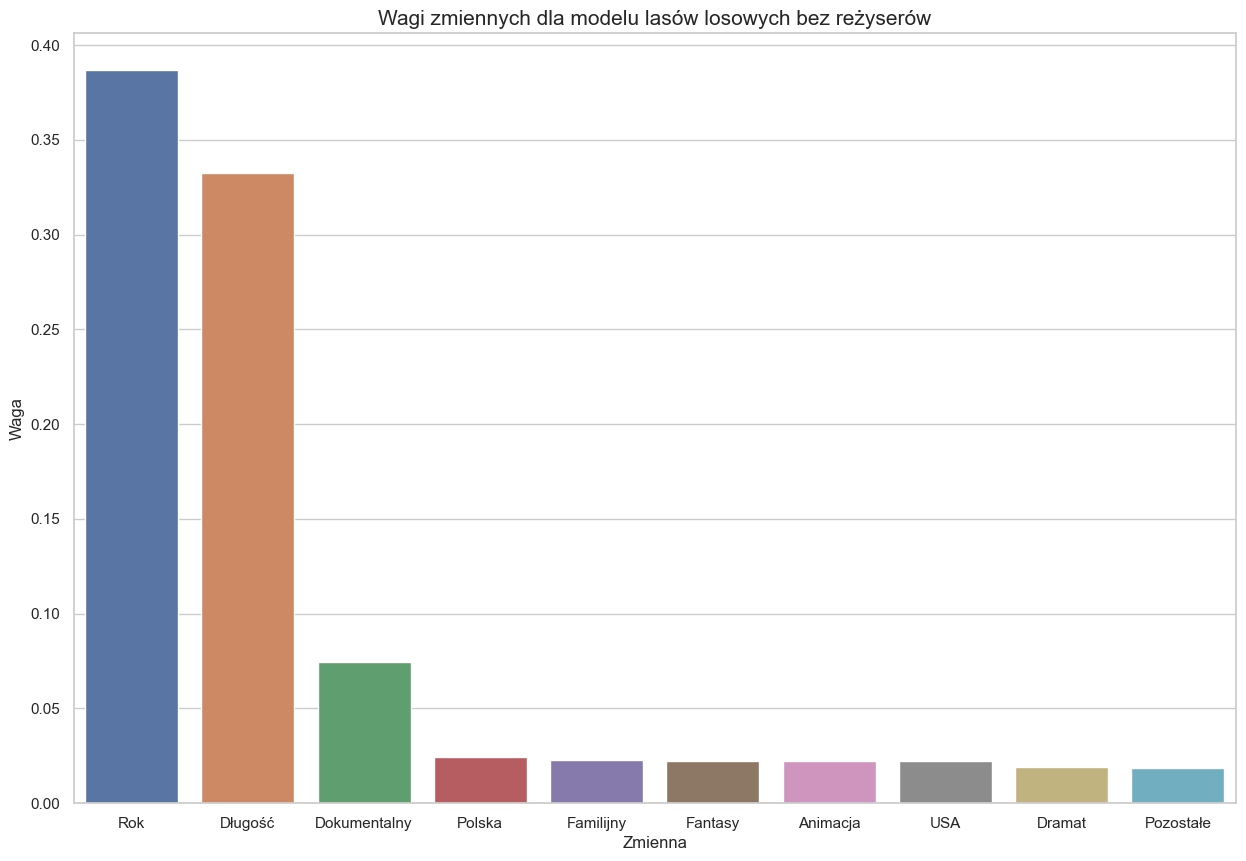

In [25]:
# wykres słupkowy ważności zmiennych
plt.figure(figsize=(15,10))
sns.barplot(x="Zmienna", y="Waga", data=best_importances_2)
plt.title("Wagi zmiennych dla modelu lasów losowych bez reżyserów", fontsize=15)
plt.show()
    

# 3\. Podsumowanie i wnioski

Na podstawie uzyskanych danych z serwisu Filmweb można w pewnym stopniu oszacować ocenę filmu na podstawie pozostałych parametrów. Modele lasów losowych dały nam dokładność dopasowania mierzoną RMSE na poziomie 0.71. Usunięcie danych o reżyserach, które są mocno skorelowane z pozostałymi kolumnami, nie pogarsza wyniku, a wielokrotnie przyspiesza obliczenia. Tak jak zauważono w analizie eksploracyjnej, rok ma duży wpływ na ocenę filmu. Na podstawie samych wag w lasach losowych nie widać czy wpływ ten jest pozytywny, czy negatywny, aczkolwiek bazując na poprzedniej części projektu, wiemy, że nowsze filmy oceniane są coraz gorzej. Drugą w kolejności wagą jest długość filmu. Z wykresu punktowego w poprzedniej części projektu można zaobserwować, że długie filmy (powyżej 3 godzin) mają oceny zawsze w zakresie 6-8. Z danych w kategorii gatunku i kraju największy wagę ma to, czy film jest dokumentalny. Z wcześniejszej analizy wiemy, że te filmy oceniane są lepiej niż średnia. Kolejnym parametrem jest Polska, gdzie średnia ocena filmu jest niższa od całej bazy danych, a szczególnie niskie oceny mają produkcje po roku 2000.